In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat
import os
from scipy.optimize import minimize 

In [2]:
def process(f): 
    d = loadmat(f)['AngSpeed_OrientTIP']
    d[:, 1] = np.sin((d[:, 1]-90)/180*np.pi)
    return d 

In [25]:
# Run this cell if we only look at the paired swimmers 

path = 'Data/SpinningRodOrientation/'
filenames = [f for f in os.listdir(path) if f.endswith('2.mat')] 
Ls = [int(f.split('_')[0][1:]) for f in filenames] 

## pair up the files 
data = [] 

for f in filenames: 
    p1 = process(path+f) 
    p2 = process(path+f[:-5]+'.mat')

    if len(p1) != len(p2):
        ll = max(len(p1), len(p2))
        if len(p1) < ll: 
            p1 = np.concatenate((p1, p2[len(p1):]))
        else: 
            p2 = np.concatenate((p2, p1[len(p2)-1:]))
    data.append((p1+p2)/2)

uni_Ls = sorted(np.unique(Ls))
agg_data = []
for L in uni_Ls: 
    single_length = np.concatenate([d for (d, l) in zip(data, Ls) if l == L])
    agg_data.append(single_length)
Ls = uni_Ls 
data = agg_data 

## Set up the bins and functions 

In [36]:
N = 19
bins = np.linspace(-0.85, 0.85, N+1)
mids = np.array([(x+y)/2 for (x, y) in zip(bins[:-1], bins[1:])])
mids_sym = mids[int((N)/2):]
Ls = np.array(Ls)

guess = [10, 100]
bounds = [[0, None]]*2

def get_V(params, Ls): 
    V = ( 0.5*np.outer(4 - params[0]/Ls, mids_sym**2) +  
             0.25*params[1]*(mids_sym**4)[np.newaxis, :])
    Z = np.sum(np.exp(-V), axis=-1)*(mids_sym[1]-mids_sym[0])
    V += np.log(Z)[:, np.newaxis]
    return V 

def cost(params, Ls, Ps): 
    # quadratic cost function
    # params in order of gamma, a, b 
    V_fit = get_V(params, Ls)
    return np.sum(V_fit*Ps)

## Bootstrap to generate more sample sets

In [37]:
MAPs = [] 
for j in range(100):
    Ps = [] 
    for i in range(len(Ls)):
        
        index_array = np.arange(len(data[i]))
        ind = np.random.choice(index_array, len(data[i]))
        resampled_data = np.array([data[i][index] for index in ind])
        
        counts, _ = np.histogram(resampled_data[:, 1], bins=bins, density=True)
        Ps.append(counts)
        
    Ps = np.array(Ps)
    Ps_sym = Ps[:, int((N)/2):] + np.flip(Ps[:, :int((N)/2)+1], axis=1)

    f = lambda x: cost(x, Ls, Ps_sym) 
    res = minimize(f, guess, bounds=bounds, method='trust-constr')
    MAPs.append(res.x)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [38]:
print(np.mean(MAPs, axis=0))
print(np.std(MAPs, axis=0))

[80.56046019 57.07519851]
[1.06317331 0.70903143]


/var/folders/5n/0rvnm9350db7gk5vdnj3tn6h0000gn/T/ipykernel_88388/2335081233.py:20: RuntimeWarning: divide by zero encountered in log
  axes[i].plot(mids_sym, -np.log(Ps_sym[i]), 'o', c=plt.cm.tab10(i))


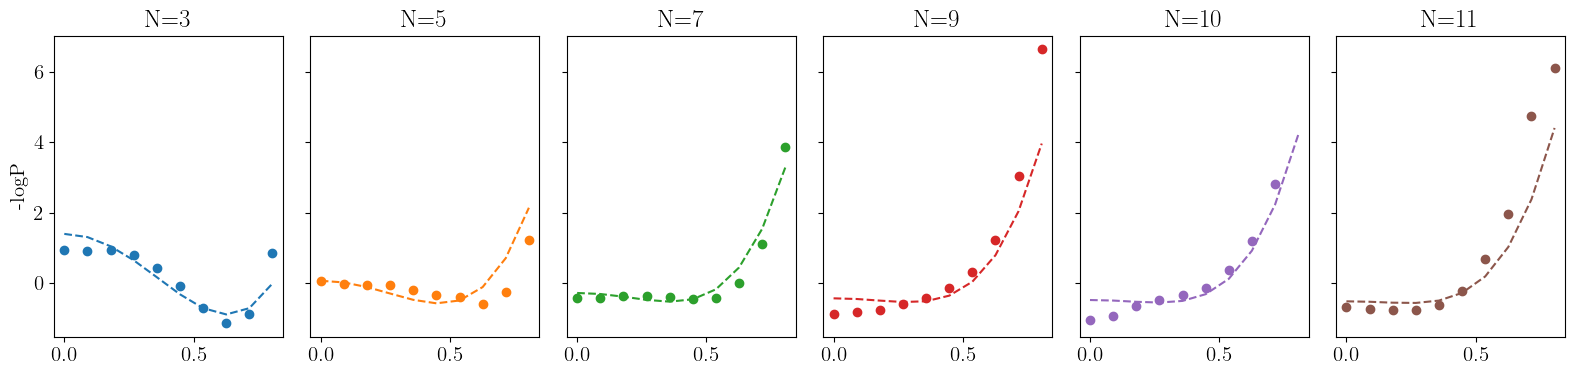

In [49]:
Ps = [] 
for i in range(len(Ls)):
    counts, _ = np.histogram(data[i][:, 1], bins=bins, density=True)
    Ps.append(counts)
Ps = np.array(Ps)
Ps_sym = Ps[:, int((N)/2):] + np.flip(Ps[:, :int((N)/2)+1], axis=1)

Ls2 = [3, 5, 7, 9, 10, 11, 30]

# guess = np.array([70, 57])
guess = np.mean(MAPs, axis=0)
V_fit = get_V(guess, Ls2)

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)

fig, axes = plt.subplots(1, len(Ls), sharex=True, sharey=True, figsize=(16, 4))

for (i, L) in enumerate(Ls): 
    axes[i].plot(mids_sym, -np.log(Ps_sym[i]), 'o', c=plt.cm.tab10(i))
    axes[i].plot(mids_sym, V_fit[i], '--', c=plt.cm.tab10(i))
    axes[i].set_title('N={}'.format(L))
axes[0].set_ylabel('-logP')
plt.tight_layout()
# plt.savefig('Figures/sr_fit.pdf')
plt.show()

/var/folders/5n/0rvnm9350db7gk5vdnj3tn6h0000gn/T/ipykernel_88388/2776561136.py:11: RuntimeWarning: divide by zero encountered in log
  plt.plot(mids_sym, -np.log(Ps_sym[i]), 'o', c=plt.cm.tab10(i))


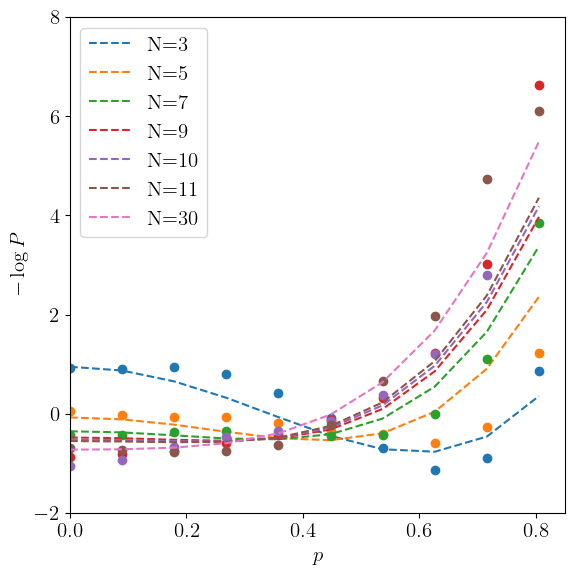

In [46]:

guess = np.array([70, 54])
V_fit = get_V(guess, Ls2)

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)

fig = plt.figure(figsize=(6, 6))

for (i, L) in enumerate(Ls2):
    if L < 30: 
        plt.plot(mids_sym, -np.log(Ps_sym[i]), 'o', c=plt.cm.tab10(i))
    plt.plot(mids_sym, V_fit[i], '--', c=plt.cm.tab10(i), label='N={}'.format(L))
plt.legend() 

plt.ylabel(r'$-\log P$')
plt.xlabel(r'$p$')
plt.legend()
plt.ylim([-2, 8])
plt.xlim([0, 0.85])
plt.tight_layout()
plt.show()

In [9]:
fits = [] 
for j in range(100):
    x = [] 
    y = [] 
    for i in range(len(Ls)):
        L = Ls[i]
        
        index_array = np.arange(len(data[i]))
        ind = np.random.choice(index_array, len(data[i]))
        resampled_data = np.array([data[i][index] for index in ind])
        x.extend(resampled_data[:, 1]) 
        y.extend(resampled_data[:, 0]*L*L)
        
        
    m, b = np.polyfit(x, y, 1)
    fits.append([m, b])

In [10]:
mean = np.mean(fits, axis=0)
std = np.std(fits, axis=0)
print(mean, std)

[74.54237056 -0.08005047] [0.12547338 0.04992407]


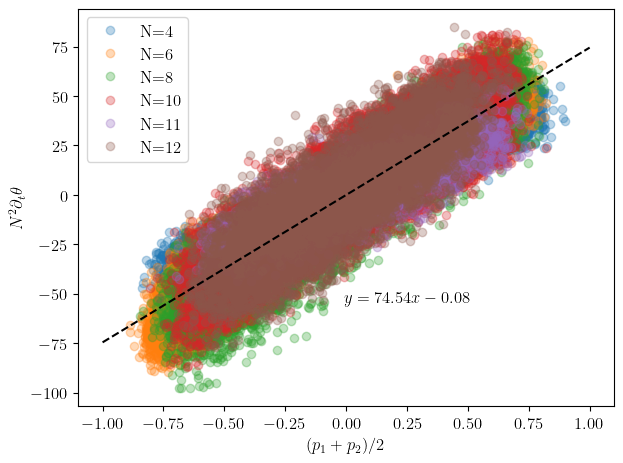

In [16]:
x = [] 
y = [] 


plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)



for (d, L) in zip(data, Ls): 
    plt.plot(d[:, 1], d[:, 0]*L*L, 'o', label='N={}'.format(L), alpha=0.3)
    x.extend(d[:, 1]) 
    y.extend(d[:, 0]*L*L)
plt.legend()
plt.ylabel(r'$  N^2   \partial_t \theta$')
plt.xlabel('$(p_1 + p_2)/2$')

X = np.linspace(-1, 1, 100)
plt.plot(X, mean[0]*X+mean[1], '--k')
plt.figtext(0.55, 0.35, r'$y = {:.2f}x {:.2f}$'.format(mean[0], mean[1]))
plt.tight_layout()
plt.savefig('Figures/sr_1.png')
plt.show() 